In [454]:
%load_ext autoreload
%autoreload 2
import os, sys
sys.path.append('..')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")
%load_ext line_profiler
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (11,8)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [455]:
from src.utils import MERFDataGenerator
from src.merf import MERF

# Test Data Generation

In [524]:
dgm = MERFDataGenerator(m=0.6, sigma_b=np.sqrt(4.5), sigma_e=1)

In [525]:
num_clusters_each_size = 20
train_sizes = [1, 3, 5, 7, 9]
known_sizes = [9, 27, 45, 63, 81]
new_sizes = [10, 30, 50, 70, 90]

In [526]:
# Smaller set that can be used for debugging
# num_clusters_each_size = 1
# train_sizes = [1, 3]
# known_sizes = [9, 27]
# new_sizes = [10, 30]

In [527]:
train_cluster_sizes = MERFDataGenerator.create_cluster_sizes_array(train_sizes, num_clusters_each_size)
known_cluster_sizes = MERFDataGenerator.create_cluster_sizes_array(known_sizes, num_clusters_each_size)
new_cluster_sizes = MERFDataGenerator.create_cluster_sizes_array(new_sizes, num_clusters_each_size)

In [528]:
len(train_cluster_sizes), len(known_cluster_sizes), len(new_cluster_sizes)

(100, 100, 100)

In [529]:
train, test_known, test_new = dgm.generate_split_samples(train_cluster_sizes, known_cluster_sizes, new_cluster_sizes)

INFO     [utils.py:135] Drew 10000 samples from 200 clusters.
INFO     [utils.py:136] PTEV = 89.84798873470334, PREV = 50.8459358269305.


In [530]:
len(train), len(test_known), len(test_new)

(500, 4500, 5000)

# MERF Training

In [531]:
X_train = train[['X_0', 'X_1', 'X_2']]
Z_train = train[['Z']]
clusters_train = train['cluster']
y_train = train['y']

In [532]:
mrf = MERF(n_estimators=300, max_iterations=20)

In [533]:
mrf.fit(X_train, Z_train, clusters_train, y_train)

INFO     [merf.py:233] GLL is 1130.8847193929864 at iteration 1.
INFO     [merf.py:233] GLL is 919.0091308989761 at iteration 2.
INFO     [merf.py:233] GLL is 910.6456926040746 at iteration 3.
INFO     [merf.py:233] GLL is 921.489097084447 at iteration 4.
INFO     [merf.py:233] GLL is 929.1065470125137 at iteration 5.
INFO     [merf.py:233] GLL is 920.9042500087833 at iteration 6.
INFO     [merf.py:233] GLL is 910.5646932461826 at iteration 7.
INFO     [merf.py:233] GLL is 908.0924659113838 at iteration 8.
INFO     [merf.py:233] GLL is 915.4976983947942 at iteration 9.
INFO     [merf.py:233] GLL is 918.6411098023992 at iteration 10.
INFO     [merf.py:233] GLL is 918.9111643006981 at iteration 11.
INFO     [merf.py:233] GLL is 920.6469776913736 at iteration 12.
INFO     [merf.py:233] GLL is 916.9592328417592 at iteration 13.
INFO     [merf.py:233] GLL is 919.0714651639997 at iteration 14.
INFO     [merf.py:233] GLL is 920.1442031437556 at iteration 15.
INFO     [merf.py:233] GLL is 917.

The GLL is flat! What is happening? Why is this not getting to a good place? 

Text(0.5,0,'Iteration')

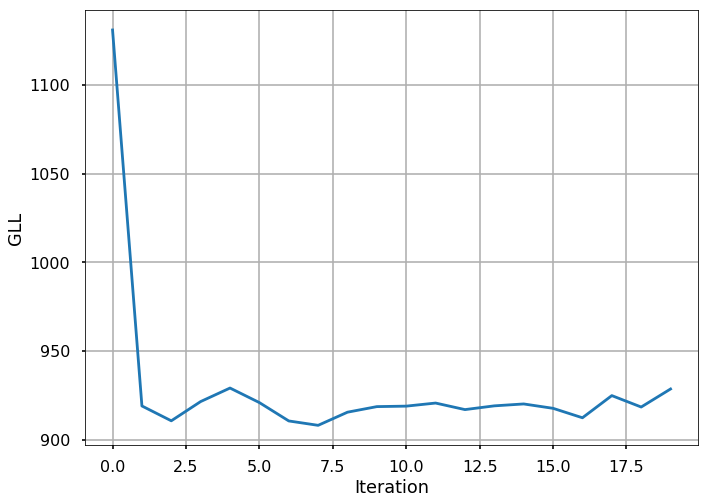

In [534]:
plt.plot(mrf.gll_history)
plt.grid('on')
plt.ylabel('GLL')
plt.xlabel('Iteration')

Text(0.5,0,'Iteration')

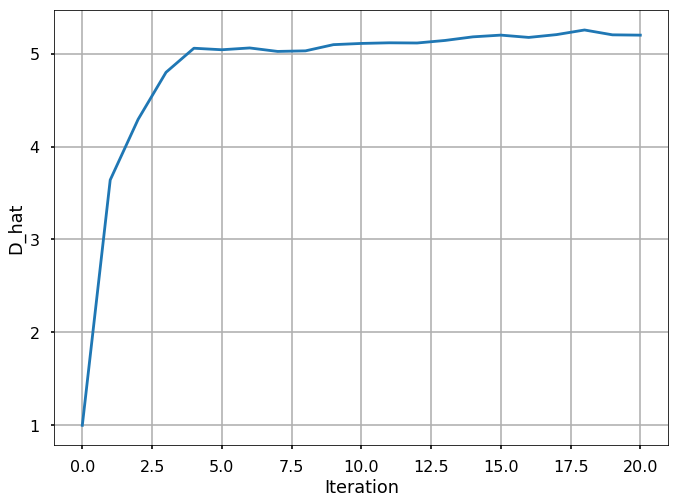

In [535]:
D_hat_history = [x[0][0] for x in mrf.D_hat_history]
plt.plot(D_hat_history)
plt.grid('on')
plt.ylabel('D_hat')
plt.xlabel('Iteration')

Text(0.5,0,'Iteration')

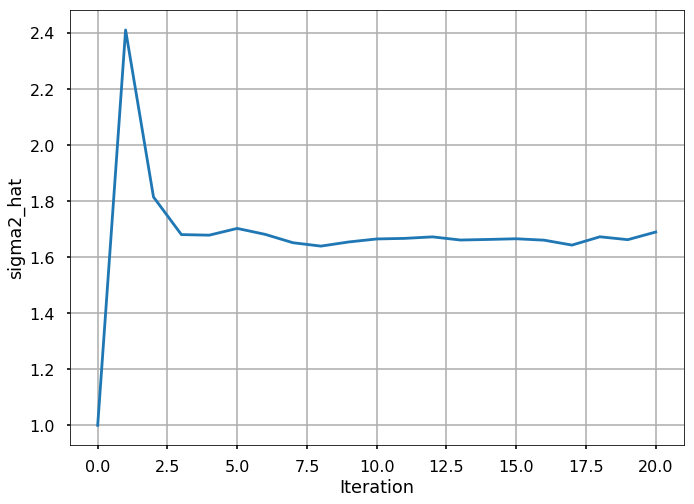

In [536]:
plt.plot(mrf.sigma2_hat_history)
plt.grid('on')
plt.ylabel('sigma2_hat')
plt.xlabel('Iteration')

# MERF Prediction

In [537]:
X_known = test_known[['X_0', 'X_1', 'X_2']]
Z_known = test_known[['Z']]
clusters_known = test_known['cluster']
y_known = test_known['y']

In [538]:
y_hat_known = mrf.predict(X_known, Z_known, clusters_known)

In [539]:
assert len(y_hat_known) == len(y_known)

In [540]:
X_new = test_new[['X_0', 'X_1', 'X_2']]
Z_new = test_new[['Z']]
clusters_new = test_new['cluster']
y_new = test_new['y']

In [541]:
y_hat_new = mrf.predict(X_new, Z_new, clusters_new)

In [542]:
assert len(y_hat_new) == len(y_new)

# MERF Accuracy

In [543]:
# Train and test using classic random forest. 
from sklearn.ensemble import RandomForestRegressor
import numpy as np

In [544]:
rf = RandomForestRegressor(n_estimators=300, n_jobs=-1)

In [545]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [546]:
y_hat_known_rf = rf.predict(X_known)

In [547]:
pmse_known_rf = np.mean((y_known - y_hat_known_rf) ** 2)
pmse_known_rf

8.0293477072660444

In [548]:
y_hat_known_merf = mrf.predict(X_known, Z_known, clusters_known)

In [549]:
pmse_known_merf = np.mean((y_known - y_hat_known_merf) ** 2)
pmse_known_merf

2.2558705112139821

In [550]:
rd_known = 100 * (pmse_known_rf - pmse_known_merf) / pmse_known_rf
rd_known

71.904685243951207

This is not expected. The MERF should have BETTER PMSE than the regular RF. What is happening? 

In [551]:
y_hat_new_rf = rf.predict(X_new)

In [552]:
pmse_new_rf = np.mean((y_new - y_hat_new_rf) ** 2)
pmse_new_rf

7.2980573678033744

In [553]:
y_hat_new_merf = mrf.predict(X_new, Z_new, clusters_new)

In [554]:
pmse_new_merf = np.mean((y_new - y_hat_new_merf) ** 2)
pmse_new_merf

6.6801815029732419

In [555]:
rd_new = 100 * (pmse_new_rf - pmse_new_merf) / pmse_new_rf
rd_new

8.4663059454149732